# TP sur les performances de Parquet

L'objectif de ce TP est de montrer l'intérêt de Parquet lorsque la taille des données augmente et qu'elles sont dénormalisées. Nous ferons en particulier une comparaison avec le format CSV.

Nous allons lire et écrire des fichiers avec Pandas, avec un protocole de test bien défini. Les données seront générées aléatoirement.

## Installation et chargement des librairies

In [1]:
%pip install pyarrow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Any, Callable, Dict, List, Tuple
import os
import shutil
import timeit
import uuid

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Génération des données

Nos données seront constituées des champs suivants :
- `usine` : nom de l'usine Transpomme (peu de valeurs distinctes)
- `variete` : nom de la variété de pomme observée (beaucoup de valeurs distinctes)
- `diametre` : diametre mesuré (un entier)
- `poids` : poids de la pomme (un flottant)

Pour pouvoir générer ces données, nous avons besoin de définir quelques paramètres :

In [12]:
USINES = ['Rouen', 'Sarlat', 'Strasbourg', 'Lorient']
VARIETES = [
    'Akane', 'Alkmène', 'Angold', 'Annurca', 'Antarès', 'Antonovka', 'Argillière',
    'Ariane', 'Ascahire', 'Berlepsch', 'Borowitsky', 'Bouvière', 'Braeburn',
    'Cabassou', 'Calypso', 'Cellini', 'Châtaignier', 'Choupette', 'Circe', 'Clivia',
    'Cloche', 'Colapuy', 'Collina', 'Court-Pendu', 'Discovery', 'Diva',
    'Delflopion', 'Chailleux', 'Florina', 'Ecolette', 'Elstar', 'Enterprise', 'Era',
    'Freedom', 'Fuji', 'Gala', 'Gaillarde', 'Galeuse', 'Golchard', 'Gosselet',
    'Goldrush', 'Gravenstein', 'HoneyCrunch', 'Idared', 'Jerseymac', 'Jonagold',
    'Karneval', 'Katja', 'Katka', 'Lanscailler', 'Lobo', 'Luna', 'Melrose',
    'Merlijn', 'McIntosh', 'Modi', 'Ontario', 'Opal', 'Pohorka', 'Pigeonnet',
    'Bismarck', 'Clochard', 'Curé', 'Sauergrauech', 'Empire', 'Rajka', 'Reanda',
    'Rebella', 'Recolor', 'Regine', 'Reglindis', 'Richard', 'Remo', 'Rene',
    'Rewena', 'Rozela', 'RubisGold', 'Sampion', 'Santana', 'Saturn', 'Sirena',
    'Spartan', 'Topaz'
]

DIAMETRE_MIN = 80
DIAMETRE_MAX = 120

POIDS_MIN = 95.
POIDS_MAX = 180.

In [44]:
def generate_dataframe(n_rows: int) -> pd.DataFrame:
    """
    Génère un dataframe Pandas de taille donnée
    """
    return pd.DataFrame({
        'usine': np.random.choice(USINES, n_rows),
        'variete': np.random.choice(VARIETES, n_rows),
        'diametre': np.random.randint(DIAMETRE_MIN, DIAMETRE_MAX, n_rows),
        'poids': POIDS_MIN + (POIDS_MAX - POIDS_MIN) * np.random.random(n_rows),
        'random': np.random.choice(VARIETES, n_rows) + np.random.choice(VARIETES, n_rows) + np.random.choice(VARIETES, n_rows) + np.random.choice(VARIETES, n_rows)
    })

In [45]:
generate_dataframe(5)

,usine,variete,diametre,poids,random
0,Lorient,Sirena,83,101.475166,AscahireIdaredCuréAntonovka
1,Lorient,Cloche,83,173.836614,CirceGaillardeGosseletClochard
2,Lorient,Cloche,95,120.491414,AscahireMcIntoshJerseymacAngold
3,Sarlat,Pigeonnet,82,141.930369,AntarèsJonagoldGaleuseColapuy
4,Lorient,Calypso,105,124.699366,TopazLunaClochardAkane


## Tests de performance

In [46]:
# Nombre de lignes à tester
# NB : attention à partir d'un million ça commence à devenir lent !
ROW_NUMBERS_TO_TEST = [
    1_000,
    10_000,
    100_000,
    200_000,
    300_000,
    400_000,
    500_000,
    750_000,
    1_000_000,
    2_000_000
]

In [18]:
# Répertoire de données où le dataframe sera stocké
DATA_DIRECTORY = 'data'
DATA_FILE = os.path.join(DATA_DIRECTORY, 'test.dat')
os.makedirs(DATA_DIRECTORY, exist_ok=True)

In [51]:
def get_file_size() -> int:
    """
    Renvoie la taille du fichier
    """
    return os.stat(DATA_FILE).st_size


def run_test(n_rows: int, n_executions: int, format: str, test_name: str, **kwargs):
    """
    Lance les mesures pour un test donné
    """
    df = generate_dataframe(n_rows)
    save_method = getattr(df, 'to_' + format)
    read_method = getattr(pd, 'read_' + format)

    result = {
        'n_rows': n_rows,
        'test_name': test_name
    }
    '''
    result['save_time'] = timeit.timeit(lambda: save_method(DATA_FILE, index=False, **kwargs), number=n_executions)
    result['full_read_time'] = timeit.timeit(lambda: read_method(DATA_FILE), number=n_executions)

    if format == 'csv':
        for column in df.columns:
            result['read_' + column] = timeit.timeit(lambda: read_method(DATA_FILE)[column], number=n_executions)
    else:
        for column in df.columns:
            result['read_' + column] = timeit.timeit(lambda: read_method(DATA_FILE, columns=[column]), number=n_executions)
    '''
    save_method(DATA_FILE, index=False, **kwargs)
    result['file_size_mb'] = get_file_size() / 1_048_576

    return result


def run_all_tests(n_executions: int) -> pd.DataFrame:
    """
    Lance toutes les mesures
    """
    all_results = []
    for n_rows in ROW_NUMBERS_TO_TEST:
        print(f'n_rows = {n_rows:_}')
        all_results.append(run_test(n_rows, n_executions, 'csv', 'csv'))
        all_results.append(run_test(n_rows, n_executions, 'parquet', 'parquet_uncompressed', compression=None))
        all_results.append(run_test(n_rows, n_executions, 'parquet', 'parquet_snappy', compression='snappy'))
        all_results.append(run_test(n_rows, n_executions, 'parquet', 'parquet_brotli', compression='brotli'))

    return pd.DataFrame(all_results)

In [52]:
results = run_all_tests(1)

n_rows = 1_000
n_rows = 10_000
n_rows = 100_000
n_rows = 200_000
n_rows = 300_000
n_rows = 400_000
n_rows = 500_000
n_rows = 750_000
n_rows = 1_000_000
n_rows = 2_000_000


In [53]:
results

,n_rows,test_name,file_size_mb
0,1000,csv,0.065407
1,1000,parquet_uncompressed,0.047589
2,1000,parquet_snappy,0.026597
3,1000,parquet_brotli,0.023206
4,10000,csv,0.650739
5,10000,parquet_uncompressed,0.445314
6,10000,parquet_snappy,0.236466
7,10000,parquet_brotli,0.191918
8,100000,csv,6.506879
9,100000,parquet_uncompressed,4.337931


## Visualisation

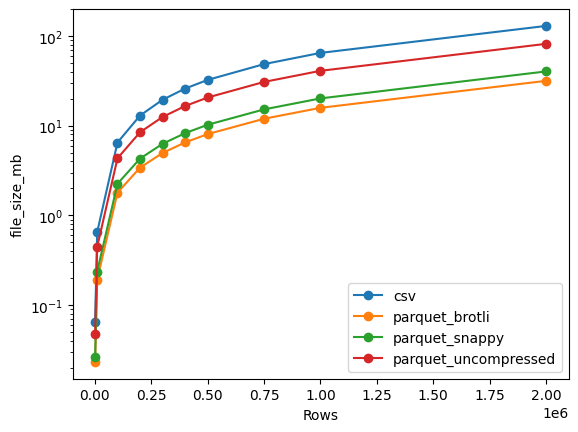

In [56]:
metrics = [c for c in results.columns if c not in ['n_rows', 'test_name']]
test_names = sorted(results['test_name'].unique())

# Affichage en échelle logarithmique
for metric in metrics:
    for test_name in test_names:
        df = results[results['test_name'] == test_name]
        plt.plot(df['n_rows'], df[metric], marker='o', label=test_name)
    plt.yscale('log')
    plt.xlabel('Rows')
    plt.ylabel(metric)
    plt.legend()
    plt.show()